In [1]:
using Plots, DifferentialEquations, StaticArrays, MonteCarloMeasurements, ControlSystems

# PD Control

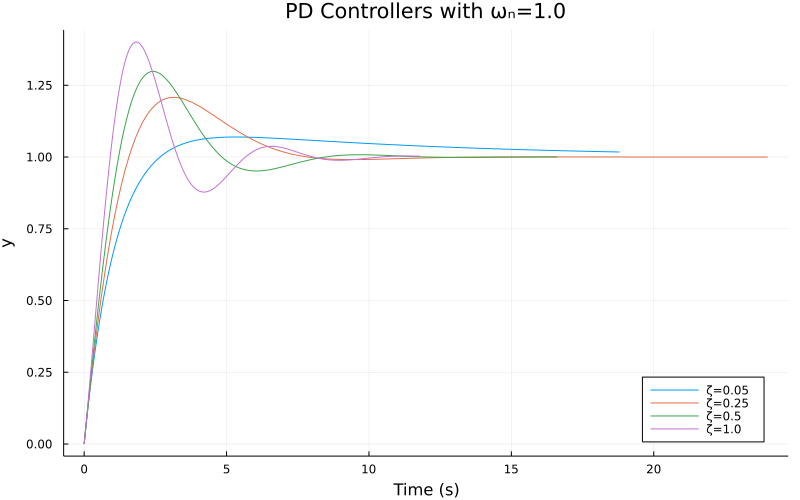

In [2]:
J = 50.0
G = tf([1], [J, 0.0, 0.0]) # linearized euler's eqn

# H_c = K_p + s K_d
# K_p = J ω_n²
# K_d = 2 J ω_n ζ

ω = 1.0
ζ1 = 0.05
H_PD1 = tf([J*ω^2, 2*J*ω*ζ1], [1])

ζ2 = 0.25
H_PD2 = tf([J*ω^2, 2*J*ω*ζ2], [1])

ζ3 = 0.5
H_PD3 = tf([J*ω^2, 2*J*ω*ζ3], [1])

ζ4 = 1.0
H_PD4 = tf([J*ω^2, 2*J*ω*ζ4], [1])

plot(step(feedback(H_PD1 * G)), title="PD Controllers with ωₙ=1.0", label="ζ=$ζ1", legend=:bottomright, size=(800,500))
plot!(step(feedback(H_PD2 * G)), label="ζ=$ζ2")
plot!(step(feedback(H_PD3 * G)), label="ζ=$ζ3")
plot!(step(feedback(H_PD4 * G)), label="ζ=$ζ4")

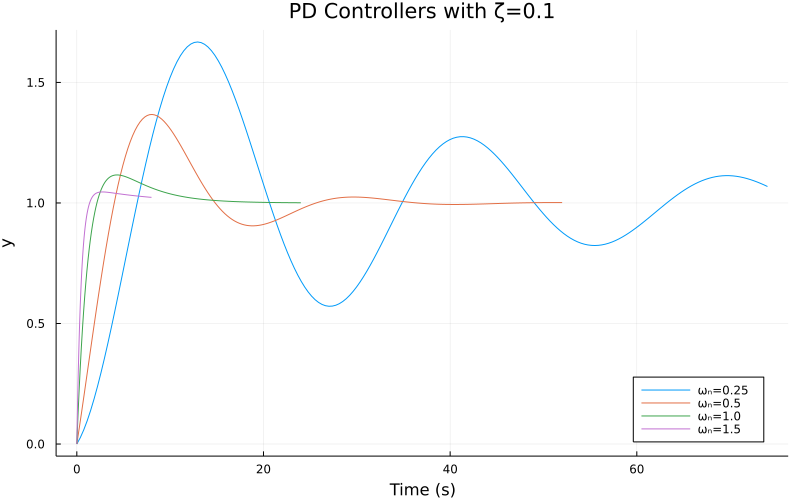

In [3]:
ζ = 0.1
ω1 = 0.25
H_PD1 = tf([J*ω1^2, 2*J*ω1*ζ], [1])

ω2 = 0.5
H_PD2 = tf([J*ω2^2, 2*J*ω2*ζ], [1])

ω3 = 1.0
H_PD3 = tf([J*ω3^2, 2*J*ω3*ζ], [1])

ω4 = 1.5
H_PD4 = tf([J*ω4^2, 2*J*ω4*ζ], [1])

plot(step(feedback(H_PD1 * G)), title="PD Controllers with ζ=0.1", label="ωₙ=$ω1", legend=:bottomright, size=(800,500))
plot!(step(feedback(H_PD2 * G)), label="ωₙ=$ω2")
plot!(step(feedback(H_PD3 * G)), label="ωₙ=$ω3")
plot!(step(feedback(H_PD4 * G)), label="ωₙ=$ω4")

# Implementing PD Control

In [4]:
function diffeq_euler(initial_conditions, time_span, params; solver_args...)
    function _differential_system(u, p, t)
        ϕ, θ, ψ, ω_x, ω_y, ω_z = u
        J_x, J_y, J_z, M_x, M_y, M_z = p
        
        return SA[
            ω_x + ω_z * tan(θ)*cos(ϕ) + ω_y*tan(θ)*sin(ϕ),
            ω_y*cos(ϕ) - ω_z*sin(ϕ),
            ω_z*sec(θ)*cos(ϕ) + ω_y*sec(θ)*sin(ϕ),
            (M_x(u, p, t) + (J_y - J_z) * ω_y * ω_z) / J_x,
            (M_y(u, p, t) + (J_z - J_x) * ω_x * ω_z) / J_y,
            (M_z(u, p, t) + (J_x - J_y) * ω_x * ω_y) / J_z
        ]
    end

    problem = ODEProblem(_differential_system, initial_conditions, time_span, params)
    solution = solve(problem; solver_args...)

    return solution
end

diffeq_euler (generic function with 1 method)

In [5]:
function Mx_func(u, p, t)
    ϕ, θ, ψ, ω_x, ω_y, ω_z = u
    ϕ̇ = ω_x + ω_z * tan(θ)*cos(ϕ) + ω_y*tan(θ)*sin(ϕ)
    
    return Kp[1]*(e_f[1] - ϕ) + Kd[1]*(ė_f[1] - ϕ̇)
end

function My_func(u, p, t)
    ϕ, θ, ψ, ω_x, ω_y, ω_z = u
    θ̇ = ω_y*cos(ϕ) - ω_z*sin(ϕ)
    
    return Kp[2]*(e_f[2] - θ) + Kd[2]*(ė_f[2] - θ̇)
end

function Mz_func(u, p, t)
    ϕ, θ, ψ, ω_x, ω_y, ω_z = u
    ψ̇ = ω_z*sec(θ)*cos(ϕ) + ω_y*sec(θ)*sin(ϕ)
    
    return Kp[3]*(e_f[3] - ψ) + Kd[3]*(ė_f[3] - ψ̇)
end

Mz_func (generic function with 1 method)

In [6]:
Js = [150.0, 100.0, 100.0]

e_f = [0.0, 0.0, 0.0]
ė_f = [0.0, 0.0, 0.0]

ωₙ = 0.2
ζ = 0.8

Kp = Js .* ωₙ^2
Kd = 2 .* Js .* ωₙ .* ζ

tspan = [0.0, 60.0]
init = SA[0.5, 0.25, -0.5, 0.0, 0.0, 0.0]
params = [Js[1], Js[2], Js[3], Mx_func, My_func, Mz_func]

sol = diffeq_euler(init, tspan, params);

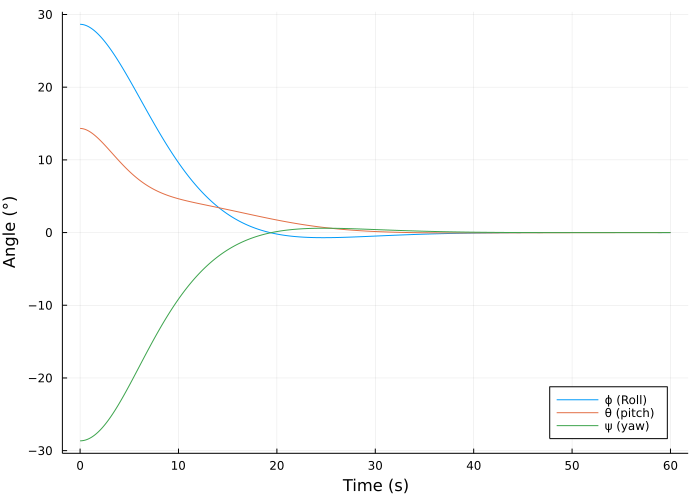

In [7]:
times = LinRange(0, tspan[2], 1000)
sol_interp = sol(times)

roll = sol_interp[1, 1:end]
pitch = sol_interp[2, 1:end]
yaw = sol_interp[3, 1:end]

plot(
    times, rad2deg.(roll), 
    label="ϕ (Roll)", 
    xlabel="Time (s)", ylabel="Angle (°)", 
    legend=:bottomright,
    size=(700,500)
)
plot!(times, rad2deg.(pitch), label="θ (pitch)")
plot!(times, rad2deg.(yaw), label="ψ (yaw)")

# Extension: Modelling Uncertainty and Monte Carlo Simulations

In [8]:
init_mcs = SA[
    0.5 + 0.05 * StaticParticles(100),
    0.0,
    0.0,
    0.01 * StaticParticles(100),
    0.0,
    0.0
]

sol_mcs = diffeq_euler(init_mcs, tspan, params);

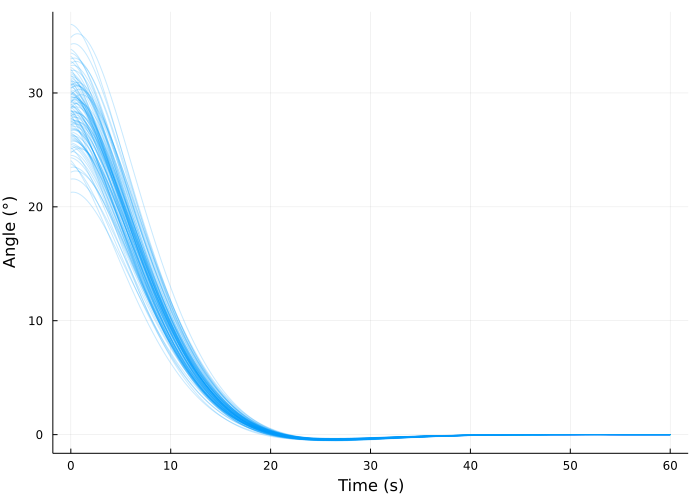

In [9]:
sol_interp_mcs = sol_mcs(times)
roll_mcs = sol_interp_mcs[1, 1:end]
pitch_mcs = sol_interp_mcs[2, 1:end]
yaw_mcs = sol_interp_mcs[3, 1:end]

mcplot(
    times, rad2deg.(roll_mcs),
    label="",
    xlabel="Time (s)", ylabel="Angle (°)", 
    legend=:topright,
    size=(700,500)
)

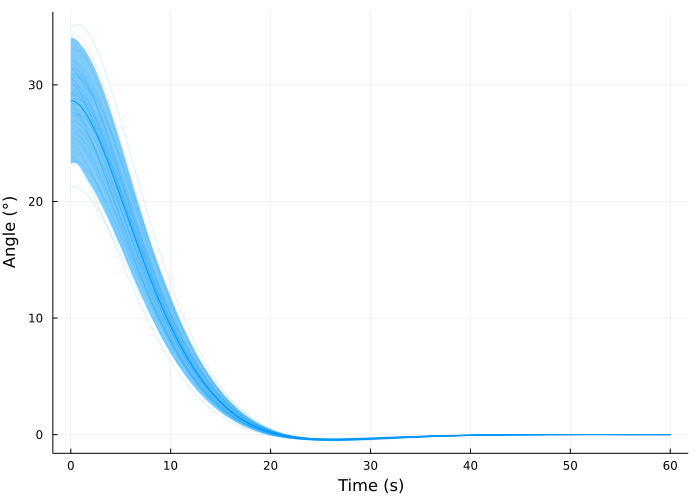

In [10]:
plot(
    times, rad2deg.(roll_mcs),
    label="",
    xlabel="Time (s)", ylabel="Angle (°)", 
    legend=:topright,
    size=(700,500)
)